# Quasi depth-first search algorithm for generating diagnostic decision trees

In [1]:
import pandas as pd
import numpy as np
import pydot
from random import shuffle, seed
from IPython.display import Image

In [2]:
df = pd.read_csv("d-matrix.csv")
# Root nodes for each decision tree
disruption_nodes = ['Input power disruption', 'Cable disruption', 
               'Transformer disruption', 'Inverter disruption', 'Motor disruption']

disruption = 'Transformer disruption'   # choice of disruption/failure node
d = df[df[disruption] == 1].drop([e for e in disruption_nodes if e != disruption], axis=1)

In [3]:
def total_keys(test_dict): # counts the number of keys in a nested dictionary
    return (0 if not isinstance(test_dict, dict)  
    else len(test_dict) + sum(total_keys(val) for val in test_dict.values())) 

def split_node(df, test_str):  
    ones = df[df[test_str] == 1].drop([test_str], axis=1)    # left child-node 
    zeros = df[df[test_str] == 0].drop([test_str], axis=1) 
    return ones, zeros

def calc_marginals(left_df, right_df):  # update Prob_unacceptable after splitting
    left_sum = left_df['Prob unacceptable'].sum()
    right_sum = right_df['Prob unacceptable'].sum()
    for l in left_df['Prob unacceptable']:
        left_df['Prob unacceptable'][left_df['Prob unacceptable'] == l] /= left_sum
    for r in right_df['Prob unacceptable']:
        right_df['Prob unacceptable'][right_df['Prob unacceptable'] == r] /= right_sum        
    return left_df, right_df

def calc_entropy(left_df, right_df):  # calculate entropy after splitting
    left_df, right_df = calc_marginals(left_df, right_df)
    entropy_ones = entropy_zeros = 0    
    for l in left_df['Prob unacceptable']:
        entropy_ones += l*np.log2(l)
    for r in right_df['Prob unacceptable']:
        entropy_zeros += r*np.log2(r)
    return -entropy_ones - entropy_zeros

def entropy_dict(df_of_tests):
    e_dict = {}
    for t in list(df_of_tests.drop(['Prob unacceptable'], axis=1)):
        l_df, r_df = split_node(df_of_tests, t)
        if l_df.empty or r_df.empty:
            entropy = -np.inf
        else:
            entropy = calc_entropy(l_df, r_df)
        e_dict.update({t:entropy})
    return e_dict


In [4]:
class QDFS:    
    def __init__(self):
        self.flag = True
        self.memory = []
    def select_test(self, df):
        if len(df) != 1:
            df_of_tests = df.drop(['Factors'] + self.memory, axis=1)
            test_dict = entropy_dict(df_of_tests)
            selected_test = max(test_dict, key=test_dict.get)
        else:
            selected_test = None
        return selected_test

    def info_gain(self, dff, first_test='Sudden change', tree=None):
        node = self.select_test(dff)

        if tree is None:
            tree = {}
            if self.flag == True:
                node = first_test
                self.flag = False
            tree[node] = {}

        for value in [1.0, 0.0]:
            self.memory.append(node)
            subtable = dff[dff[node] == value]
            if self.select_test(subtable) is not None:
                node2 = self.select_test(subtable)
            else:
                node2 = node

            subtable2 = dff[dff[node2] == value]
            class_value, counts = np.unique(subtable['Factors'], return_counts=True)
            class_value2, counts2 = np.unique(subtable2['Factors'], return_counts=True)

            if len(d) == 2:
                print('len(d) == 2')
                tree[node][class_value2[0]] = {}
                tree[node][[c for c in class_value if c not in class_value2][0]] = {}
                return tree
            else:
                if len(counts) == 1:
                    tree[node][class_value[0]] = {}
                elif len(counts2) > len(counts) or len(counts2) == 0:
                    tree[node][node2] = {}
                    val_params = [val for val in class_value if val in class_value2]
                    nonsubset = [ns for ns in class_value if ns not in class_value2]
                    if value == 0.0:
                        str_n = ''
                        for n in nonsubset:
                            str_n += n + ', '
                        str_n = str_n[0:-2]
                        str_v = ''
                        for v in val_params:
                            str_v += v + ', '
                        str_v = str_v[0:-2]

                        tree[node][node2][str_n] = {}
                        tree[node][node2][str_v] = {}

                    if value == 1.0:
                        str_n = ''
                        for n in nonsubset:
                            str_n += n + ', '
                        str_n = str_n[0:-2]
                        str_v = ''
                        for v in val_params:
                            str_v += v + ', '
                        str_v = str_v[0:-2]                    
                        tree[node][node2][str_v] = {}
                        tree[node][node2][str_n] = {}                    

                else:
                    tree[node][node2] = self.info_gain(subtable)
        return tree    

In [5]:
event_nodes = list(df.drop(['Factors', 'Prob unacceptable'], axis=1).astype(float))
tests = [e for e in event_nodes if e not in disruption_nodes]
shuffle(tests)
tests = [tests[i] for i in range(2)] # select the number of BFS/"first test" nodes to display

In [6]:
qdfs = QDFS()
dict_list = []

for test in tests:
    tree_dict = qdfs.info_gain(d, first_test=test)
    dict_list.append(tree_dict)

/home/wych/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/wych/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


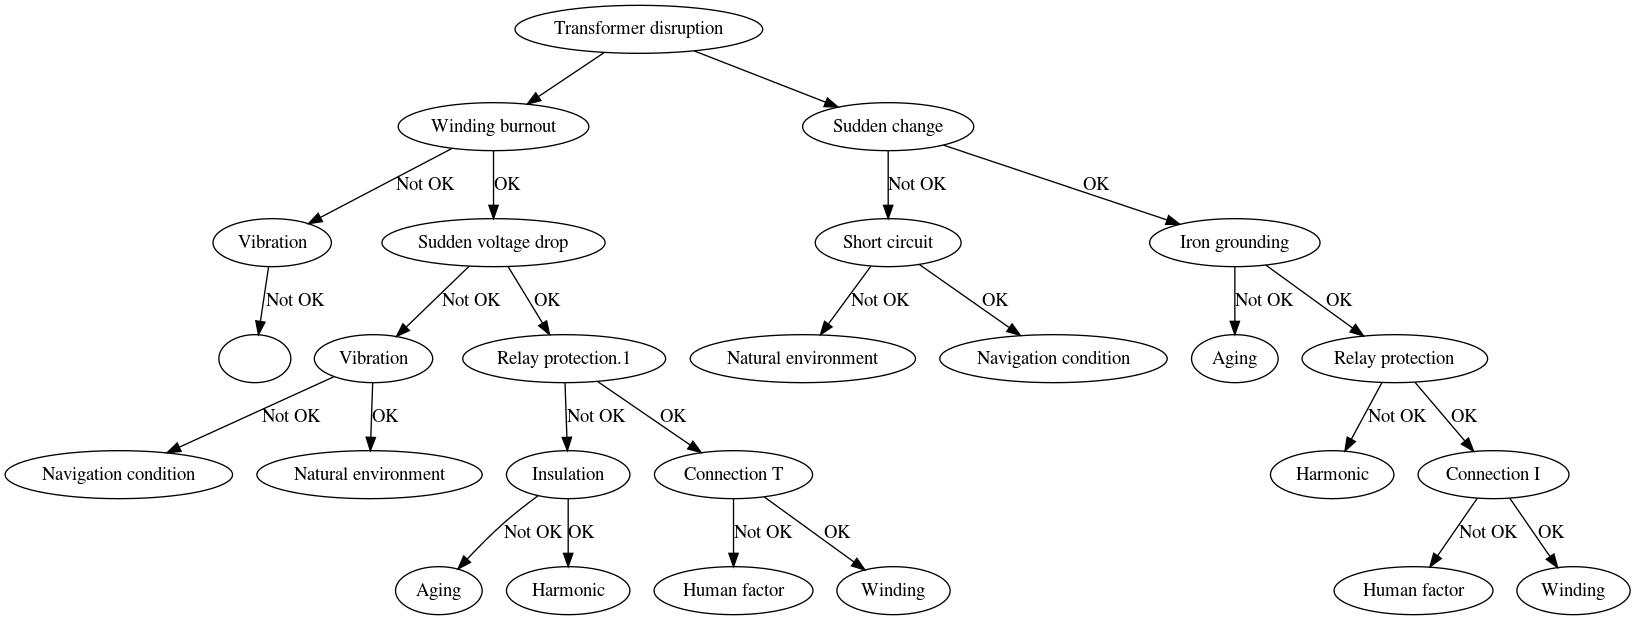

In [7]:
def dict2graph(graph, dictionary, parent_node=None):
    '''
    Parsing a nested dictionary to build a decision tree
    '''
    count = 0
    k_mem = []
    for k in dictionary:
        if parent_node is not None:
            from_name = parent_node.get_name().replace("\"", "") + '_' + k
            from_label = k
            k_mem.append(k)
            if parent_node.get_name().split('_')[-1].replace('"', "") != k:
                node_from = pydot.Node(from_name, label=from_label)
                graph.add_node(node_from)
                if count%2:
                    graph.add_edge(pydot.Edge(parent_node, node_from, label='OK'))
                else:
                    graph.add_edge(pydot.Edge(parent_node, node_from, label='Not OK'))
                count += 1              
            else:
                node_from = pydot.Node(parent_node.get_name(), label=k_mem[-1])
            if total_keys(dictionary[k]) != 3:
                dict2graph(graph, dictionary[k], node_from)
            
            else: #leaf node
                to_name0 = k + '_' + list(dict(dictionary[k].values()).keys())[0]
                to_name1 = k + '_' + list(dict(dictionary[k].values()).values())[0]               
                to_label0 = list(dict(dictionary[k].values()).keys())[0]
                to_label1 = list(dict(dictionary[k].values()).values())[0]                
                node_to0 = pydot.Node(to_name0, label=to_label0)
                node_to1 = pydot.Node(to_name1, label=to_label1)               
                graph.add_node(node_to0)
                graph.add_node(node_to1)
                graph.add_edge(pydot.Edge(node_from, node_to0, label='Not OK'))         
                graph.add_edge(pydot.Edge(node_from, node_to1, label='OK'))                
        else:                      #parent node
            from_name = from_label = k
            node_from = pydot.Node(from_name, label=from_label)
            dict2graph(graph, dictionary[k], node_from)
    return graph

def plot_one_branch(tree, name):
    graph = pydot.Dot(graph_type='digraph')    
    dict2graph(graph, tree)
    graph.write_png(name+'.png')    

def plot_tree(dict_list, name, topnode_name):
    out_graph = pydot.Dot(graph_type='digraph',compound='true')
    topmost_node = pydot.Node(topnode_name, label=topnode_name)
    out_graph.add_node(topmost_node)
    for d in dict_list:
        graph = pydot.Dot(graph_type='digraph') 
        g = dict2graph(graph, d)
        for node in g.get_nodes():
            out_graph.add_node(node)
        for edge in g.get_edges():
            out_graph.add_edge(edge)
        strg = str(g.get_nodes()[0])
        out_graph.add_edge(pydot.Edge(topmost_node, strg.split('_')[0].replace('"', "")))
    out_graph.write_png(name+'.png')   

plot_tree(dict_list, 'diagnostic_tree', disruption)
Image('diagnostic_tree.png')